In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('__file__'), '..', 'Features'))
import world_constructions as WC

c:\Users\juand\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\juand\anaconda3\Lib\site-packages\transformers\utils\generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\juand\anaconda3\Lib\site-packages\transformers\utils\generic.py:339: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Loading data

In [3]:
df_lux = WC.world_construction.init_luxury_gallery()
df_ret = WC.world_construction.init_retail_gallery()    

In [4]:
df = pd.concat([df_lux,df_ret])

In [5]:
df.head(2)

,id,prod_id,Detail,Summary,Brand,Price,base64
0,4,4,Type: Shirt / Fit: Regular fit / Sleeve...,"The shirt from Gucci, as shown in the images, ...",Gucci,1300.0,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
1,2,2,Type: Shirt / Fit: Regular fit / Sleeve...,The showcased shirt is a Gucci Oxford cotton s...,Gucci,650.0,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."


## Transoforming details into columns

In [6]:
final_df = pd.DataFrame()

for parent_row in df.Detail: 
    x = []
    for row in parent_row.split('/'):
        x.append(row.split(':'))

    temp_dataframe = pd.DataFrame(x)
    temp_dataframe[0] = temp_dataframe[0].str.lower()
    temp_dataframe = temp_dataframe.sort_values(by=0)
    temp_dataframe = temp_dataframe.groupby(0)[1].apply(lambda x: ', '.join(x)).reset_index()
        
    temp_dataframe = temp_dataframe.set_index(0).T
    temp_dataframe.columns = temp_dataframe.columns.str.lstrip()
    
    final_df = pd.concat([final_df,temp_dataframe], ignore_index = True)

final_df['seasson'] = final_df['season'].combine_first(final_df['seasson'])
final_df = final_df.drop('season', axis=1)

In [7]:
mask_duplicates = final_df.duplicated()

In [8]:
final_df['prod_id'] = df['prod_id'].values

In [9]:
final_df.head(1)

,breathability,collar style,colors,details and embellishments,fabric weight,fit,fluidity of fabric,formality,lapel,length,...,pocket placement,pocket presence,pocket size,shape,sleeve style,texture,transparency,type,seasson,prod_id
0,High,Button-down,"60% White, 20% Red, 20% Green",Buttons,Light,Regular fit,High,Business Casual,Not applicable,Hip-length,...,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,Shirt,"Spring, Summer, Autumn",4


In [10]:
print(df.shape)
print(final_df.shape)

(154, 7)
(154, 25)


In [11]:
df_images = df[['prod_id','base64']]

In [12]:
df.drop(['Detail','id','base64'],axis=1,inplace=True)

In [13]:
df = pd.merge(df,final_df,on='prod_id')

In [14]:
df.head(1)

,prod_id,Summary,Brand,Price,breathability,collar style,colors,details and embellishments,fabric weight,fit,...,patterns placement,pocket placement,pocket presence,pocket size,shape,sleeve style,texture,transparency,type,seasson
0,4,"The shirt from Gucci, as shown in the images, ...",Gucci,1300.0,High,Button-down,"60% White, 20% Red, 20% Green",Buttons,Light,Regular fit,...,Throughout,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,Shirt,"Spring, Summer, Autumn"


In [15]:
df[mask_duplicates]

,prod_id,Summary,Brand,Price,breathability,collar style,colors,details and embellishments,fabric weight,fit,...,patterns placement,pocket placement,pocket presence,pocket size,shape,sleeve style,texture,transparency,type,seasson
109,110,"The top showcased in the images is a black, fl...",Mango,29.99,Medium,Crew neck,100% Black,Not applicable,Medium,Regular fit,...,Not applicable,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,Top - Shirt,"Autumn, Winter"
136,36,The top showcased in the images is a stylish a...,HM,9.99,High,Crew neck,White (100%),Not applicable,Light,Regular fit,...,Not applicable,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,"Top, Shirt","Spring, Summer"
137,43,The top showcased in the images is a classic s...,HM,25.99,High,Crew neck,White (100%),Not applicable,Light,Regular fit,...,Not applicable,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,"Top, Shirt","Spring, Summer, Autumn"


#### Summary transformation

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [17]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\juand\anaconda3\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     c:\Users\juand\anaconda3\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
# Lowercase the descriptions
df['Summary_treated'] = df['Summary'].str.lower()

# Remove punctuation
df['Summary_treated'] = df['Summary_treated'].str.translate(str.maketrans('', '', string.punctuation))

# Remove stop words
stop = set(stopwords.words('english'))
df['Summary_treated'] = df['Summary_treated'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# Lemmatize the words
lemmatizer = WordNetLemmatizer()
df['Summary_treated'] = df['Summary_treated'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [19]:
df[['Summary','Summary_treated']].head()

,Summary,Summary_treated
0,"The shirt from Gucci, as shown in the images, ...",shirt gucci shown image silk piece inspired su...
1,The showcased shirt is a Gucci Oxford cotton s...,showcased shirt gucci oxford cotton shirt gg s...
2,The top showcased in the images is a Gucci flo...,top showcased image gucci floral lace top feat...
3,The shirt shown in the images is a light beige...,shirt shown image light beige camicia gabardin...
4,The showcased shirt is a Gucci poplin cotton t...,showcased shirt gucci poplin cotton top inspir...


## NLP on summary


#### word freq

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the descriptions
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit(df['Summary_treated'])

In [21]:
df.Brand.unique()

array(['Gucci', 'Prada', 'HM', 'Mango'], dtype=object)

In [22]:
# Example: Check for common words in luxury vs retail brands
luxury_brands = ['Gucci', 'Prada']  # Add your luxury brands here
retail_brands = ['HM', 'Mango']  # Add your retail brands here

luxury_desc = df[df['Brand'].isin(luxury_brands)]['Summary_treated']
retail_desc = df[df['Brand'].isin(retail_brands)]['Summary_treated']

In [23]:
# Create a vectorized function to remove "sleeve"
def remove_sleeve(sentence):
    sentence = sentence.replace('feature', '')
    sentence = sentence.replace('shirt', '')
    sentence = sentence.replace('suitable', '')
    sentence = sentence.replace('making', '')
    sentence = sentence.replace('fabric', '')
    sentence = sentence.replace('occasion', '')
    sentence = sentence.replace('look', '')
    sentence = sentence.replace('ensuring', '')
    sentence = sentence.replace('style', '')
    sentence = sentence.replace('showcased', '')
    sentence = sentence.replace('adding', '')
    sentence = sentence.replace('visible', '')
    sentence = sentence.replace('ideal', '')
    sentence = sentence.replace('standard', '')
    sentence = sentence.replace('image', '')
    sentence = sentence.replace('sleeve', '')
    sentence = sentence.replace('long', '')
    sentence = sentence.replace('collar', '')
    sentence = sentence.replace('color', '')
    sentence = sentence.replace('material', '')
    sentence = sentence.replace('gucci', '')
    sentence = sentence.replace('season', '')
    sentence = sentence.replace('fit', '')
    sentence = sentence.replace('summer', '')
    sentence = sentence.replace('spring', '')
    sentence = sentence.replace('touch', '')
    sentence = sentence.replace('appears', '')
    sentence = sentence.replace('enhancing', '')
    sentence = sentence.replace('length', '')

    return sentence

In [24]:
def create_common_Words(df):

    luxury_brands = ['Gucci', 'Prada']  # Add your luxury brands here
    retail_brands = ['HM', 'Mango']  # Add your retail brands here

    luxury_desc = df[df['Brand'].isin(luxury_brands)]['Summary_treated']
    retail_desc = df[df['Brand'].isin(retail_brands)]['Summary_treated']

    # Apply the function to the array
    luxury_desc = np.vectorize(remove_sleeve)(luxury_desc)
    retail_desc = np.vectorize(remove_sleeve)(retail_desc)

    luxury_words = vectorizer.transform(luxury_desc)
    retail_words = vectorizer.transform(retail_desc)


    luxury_words_df = pd.DataFrame(luxury_words.toarray(), columns=vectorizer.get_feature_names_out())
    retail_words_df = pd.DataFrame(retail_words.toarray(), columns=vectorizer.get_feature_names_out())


    # Most common words in luxury vs retail
    luxury_common_words = luxury_words_df.sum().sort_values(ascending=False).head(20)
    retail_common_words = retail_words_df.sum().sort_values(ascending=False).head(20)


    plt.figure(figsize=(10, 6))
    sns.barplot(x=luxury_common_words.values, y=luxury_common_words.index, palette='viridis')
    plt.title('Top 20 Words in Luxury Descriptions')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=retail_common_words.values, y=retail_common_words.index, palette='viridis')
    plt.title('Top 20 Words in Retail Descriptions')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()


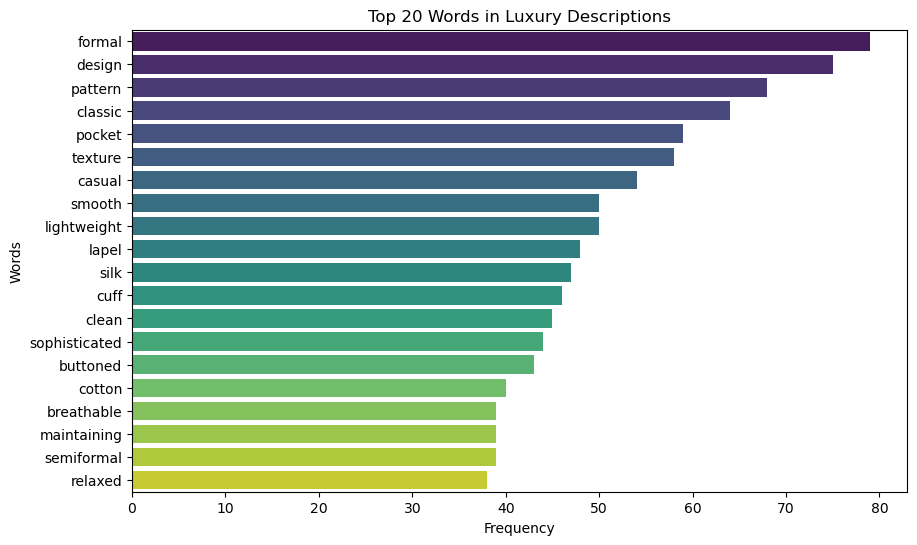

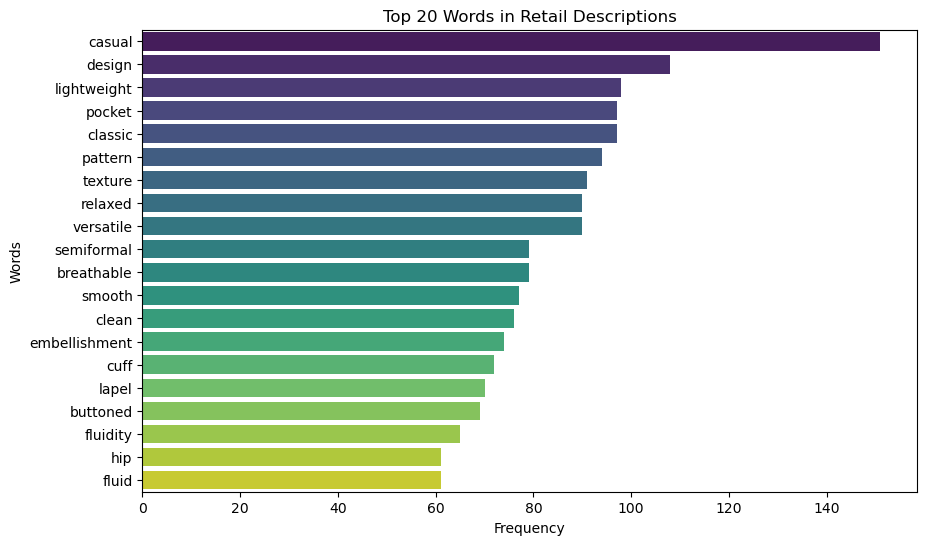

In [25]:
create_common_Words(df=df)

#### Clustering
- Hierarchical clustering heatmap
- array of cosine distances luxury vs retail
- dendogramas son con structure

In [26]:
from sentence_transformers import SentenceTransformer

In [27]:
# Step 2: Load the model
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)

In [28]:
df.head(1)

,prod_id,Summary,Brand,Price,breathability,collar style,colors,details and embellishments,fabric weight,fit,...,pocket placement,pocket presence,pocket size,shape,sleeve style,texture,transparency,type,seasson,Summary_treated
0,4,"The shirt from Gucci, as shown in the images, ...",Gucci,1300.0,High,Button-down,"60% White, 20% Red, 20% Green",Buttons,Light,Regular fit,...,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,Shirt,"Spring, Summer, Autumn",shirt gucci shown image silk piece inspired su...


In [29]:
retail_df = df[df['Brand'].isin(retail_brands)]
luxury_df = df[df['Brand'].isin(luxury_brands)]

In [30]:
embeddings_luxury = model.encode(luxury_df['Summary_treated'])
norms = np.linalg.norm(embeddings_luxury, axis=1, keepdims=True)
# Avoid division by zero
norms[norms == 0] = 1   
# Normalize each row by its L2 norm
embeddings_luxury = embeddings_luxury / norms

In [31]:
retail_df.reset_index(drop=True,inplace=True)

In [32]:
embeddings_retail = model.encode(retail_df['Summary_treated'])
norms = np.linalg.norm(embeddings_retail, axis=1, keepdims=True)
# Avoid division by zero
norms[norms == 0] = 1
# Normalize each row by its L2 norm
embeddings_retail = embeddings_retail / norms

In [33]:
distances_df = pd.DataFrame(np.matmul(embeddings_luxury,embeddings_retail.T))

In [34]:
print(embeddings_luxury.shape)
print(embeddings_retail.shape)

(58, 768)
(96, 768)


In [35]:
hierarchical_columns=[
        'breathability', 'collar style',
        'colors', 'details and embellishments', 'fabric weight', 'fit',
        'fluidity of fabric', 'formality', 'lapel', 'length', 'material',
        'neckline', 'occasion suitability', 'patterns', 'patterns placement',
        'pocket placement', 'pocket presence', 'pocket size', 'shape',
        'sleeve style', 'texture', 'transparency', 'type', 'seasson'
    ]

In [36]:
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

In [37]:
retail_df[hierarchical_columns].shape

(96, 24)

In [38]:
luxury_df[hierarchical_columns].shape

(58, 24)

In [39]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import mode

In [40]:
encoded_retail_df = pd.DataFrame(data=np.empty((96, 24)),columns=hierarchical_columns)

# Step 3: Generate Embeddings for each category column
embeddings = {cat: model.encode(retail_df[cat].tolist()) for cat in hierarchical_columns}

# Step 4: Compute Centroid for each category
centroids = {cat: mode(embeds, axis=0).mode for cat, embeds in embeddings.items()}

# Step 5: Calculate Cosine Distance between each embedding and the centroid
cosine_distances_dict = {cat: cosine_distances(embeds, centroids[cat].reshape(1, -1)).flatten() for cat, embeds in embeddings.items()}

# Step 6: Aggregate Results to get a single row for cat_i_embedded
# In this case, we'll average the distances to create a single embedding representation
embedded_results = {f'{cat}': distances for cat, distances in cosine_distances_dict.items()}

# Add the results to the original DataFrame
for cat, distances in embedded_results.items():
    encoded_retail_df[cat] = distances

x = retail_df.Brand.values == 'Mango'
encoded_retail_df['Brand'] =  x*10

In [41]:
encoded_luxury_df = pd.DataFrame(data=np.empty((58, 24)),columns=hierarchical_columns)

# Step 3: Generate Embeddings for each category column
embeddings = {cat: model.encode(luxury_df[cat].tolist()) for cat in hierarchical_columns}

# Step 4: Compute Centroid for each category
centroids = {cat: mode(embeds, axis=0).mode for cat, embeds in embeddings.items()}

# Step 5: Calculate Cosine Distance between each embedding and the centroid
cosine_distances_dict = {cat: cosine_distances(embeds, centroids[cat].reshape(1, -1)).flatten() for cat, embeds in embeddings.items()}

# Step 6: Aggregate Results to get a single row for cat_i_embedded
# In this case, we'll average the distances to create a single embedding representation
embedded_results = {f'{cat}': distances for cat, distances in cosine_distances_dict.items()}

for cat, distances in embedded_results.items():
    
    encoded_luxury_df[cat] = distances

x = luxury_df.Brand.values == 'Gucci'
encoded_luxury_df['Brand'] =  x*10

In [42]:
# Hierarchical clustering on retail and luxury categories
retail_linkage = linkage(encoded_retail_df, method='average', metric='euclidean')
luxury_linkage = linkage(encoded_luxury_df, method='average', metric='euclidean')

In [43]:
encoded_retail_df['prod_id'] = retail_df['prod_id'].reset_index(drop=True)
encoded_luxury_df['prod_id'] = luxury_df['prod_id'].reset_index(drop=True)

In [44]:
# Order of product IDs after clustering
retail_order = retail_df.iloc[leaves_list(retail_linkage)]['prod_id'].index
luxury_order = luxury_df.iloc[leaves_list(luxury_linkage)]['prod_id'].index

In [45]:
distances.shape

(58,)

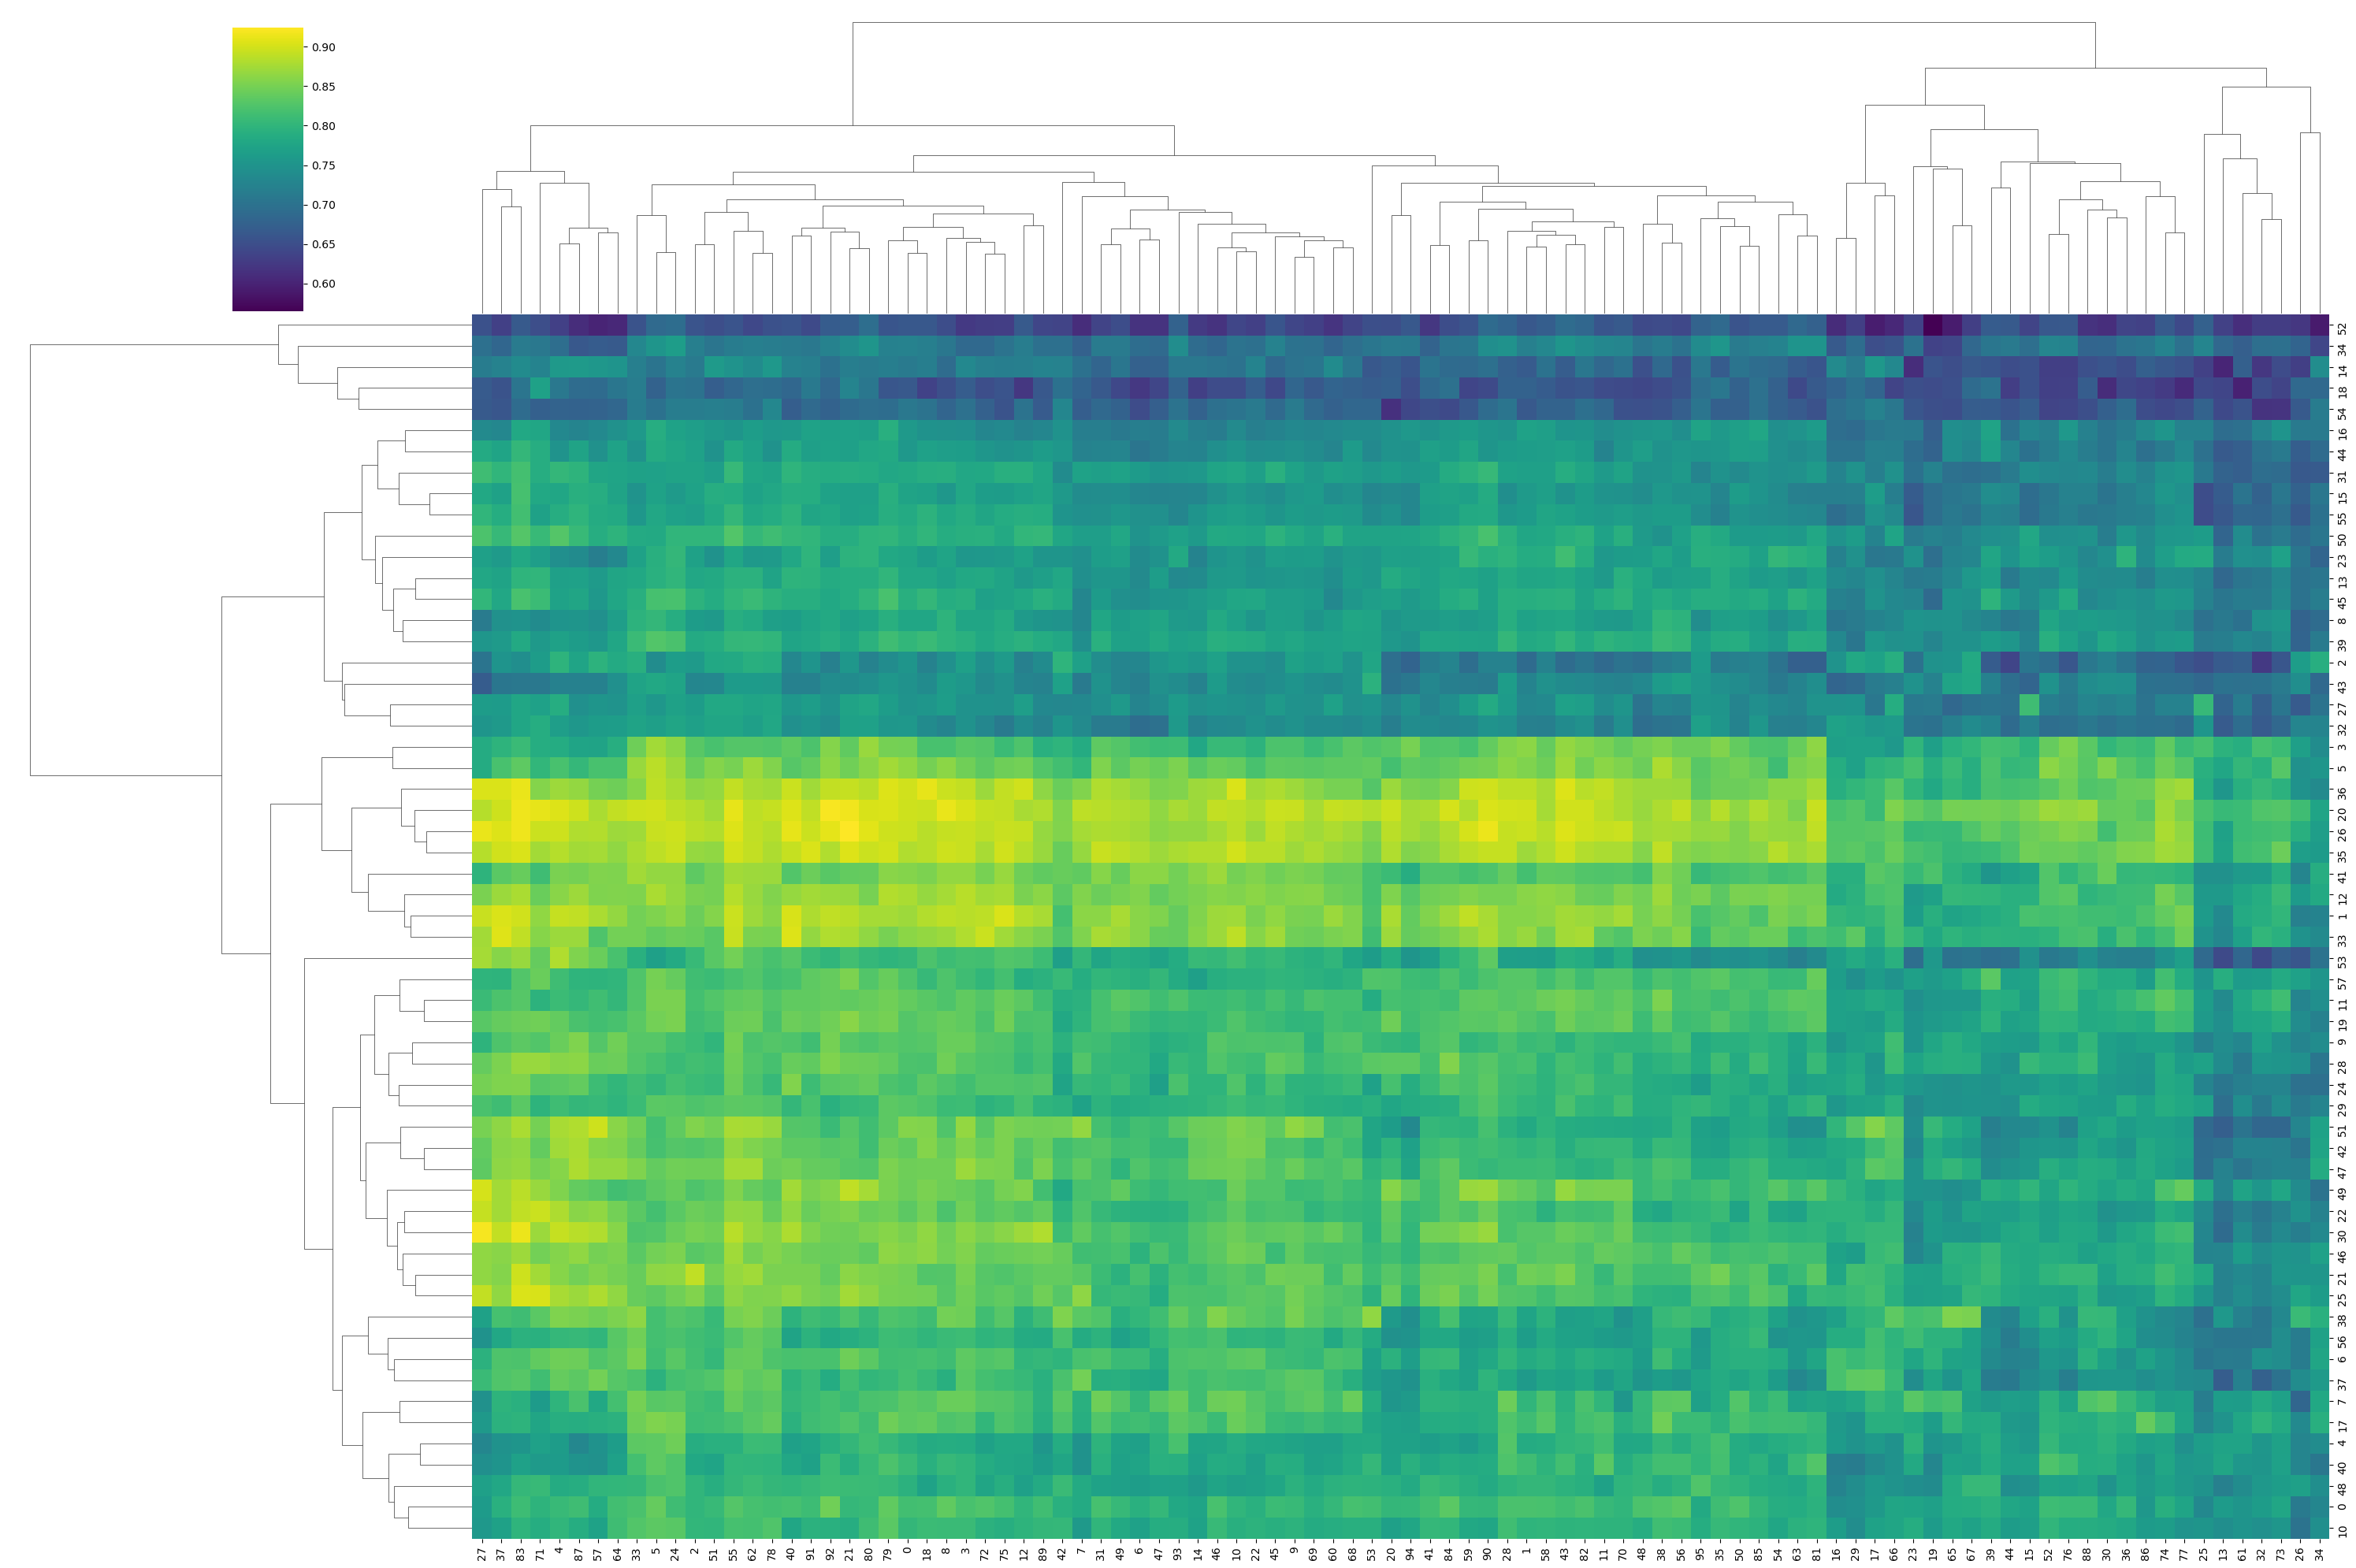

In [46]:
clustermap = sns.clustermap(
    distances_df,
    cmap='viridis',
    figsize=(30, 20),  # Set the figure size here
    dendrogram_ratio=(0.2, 0.2),  # Adjust the dendrogram ratio if needed
    cbar_pos=(0.1, 0.8, 0.03, 0.18)  # Adjust the color bar position if needed
)

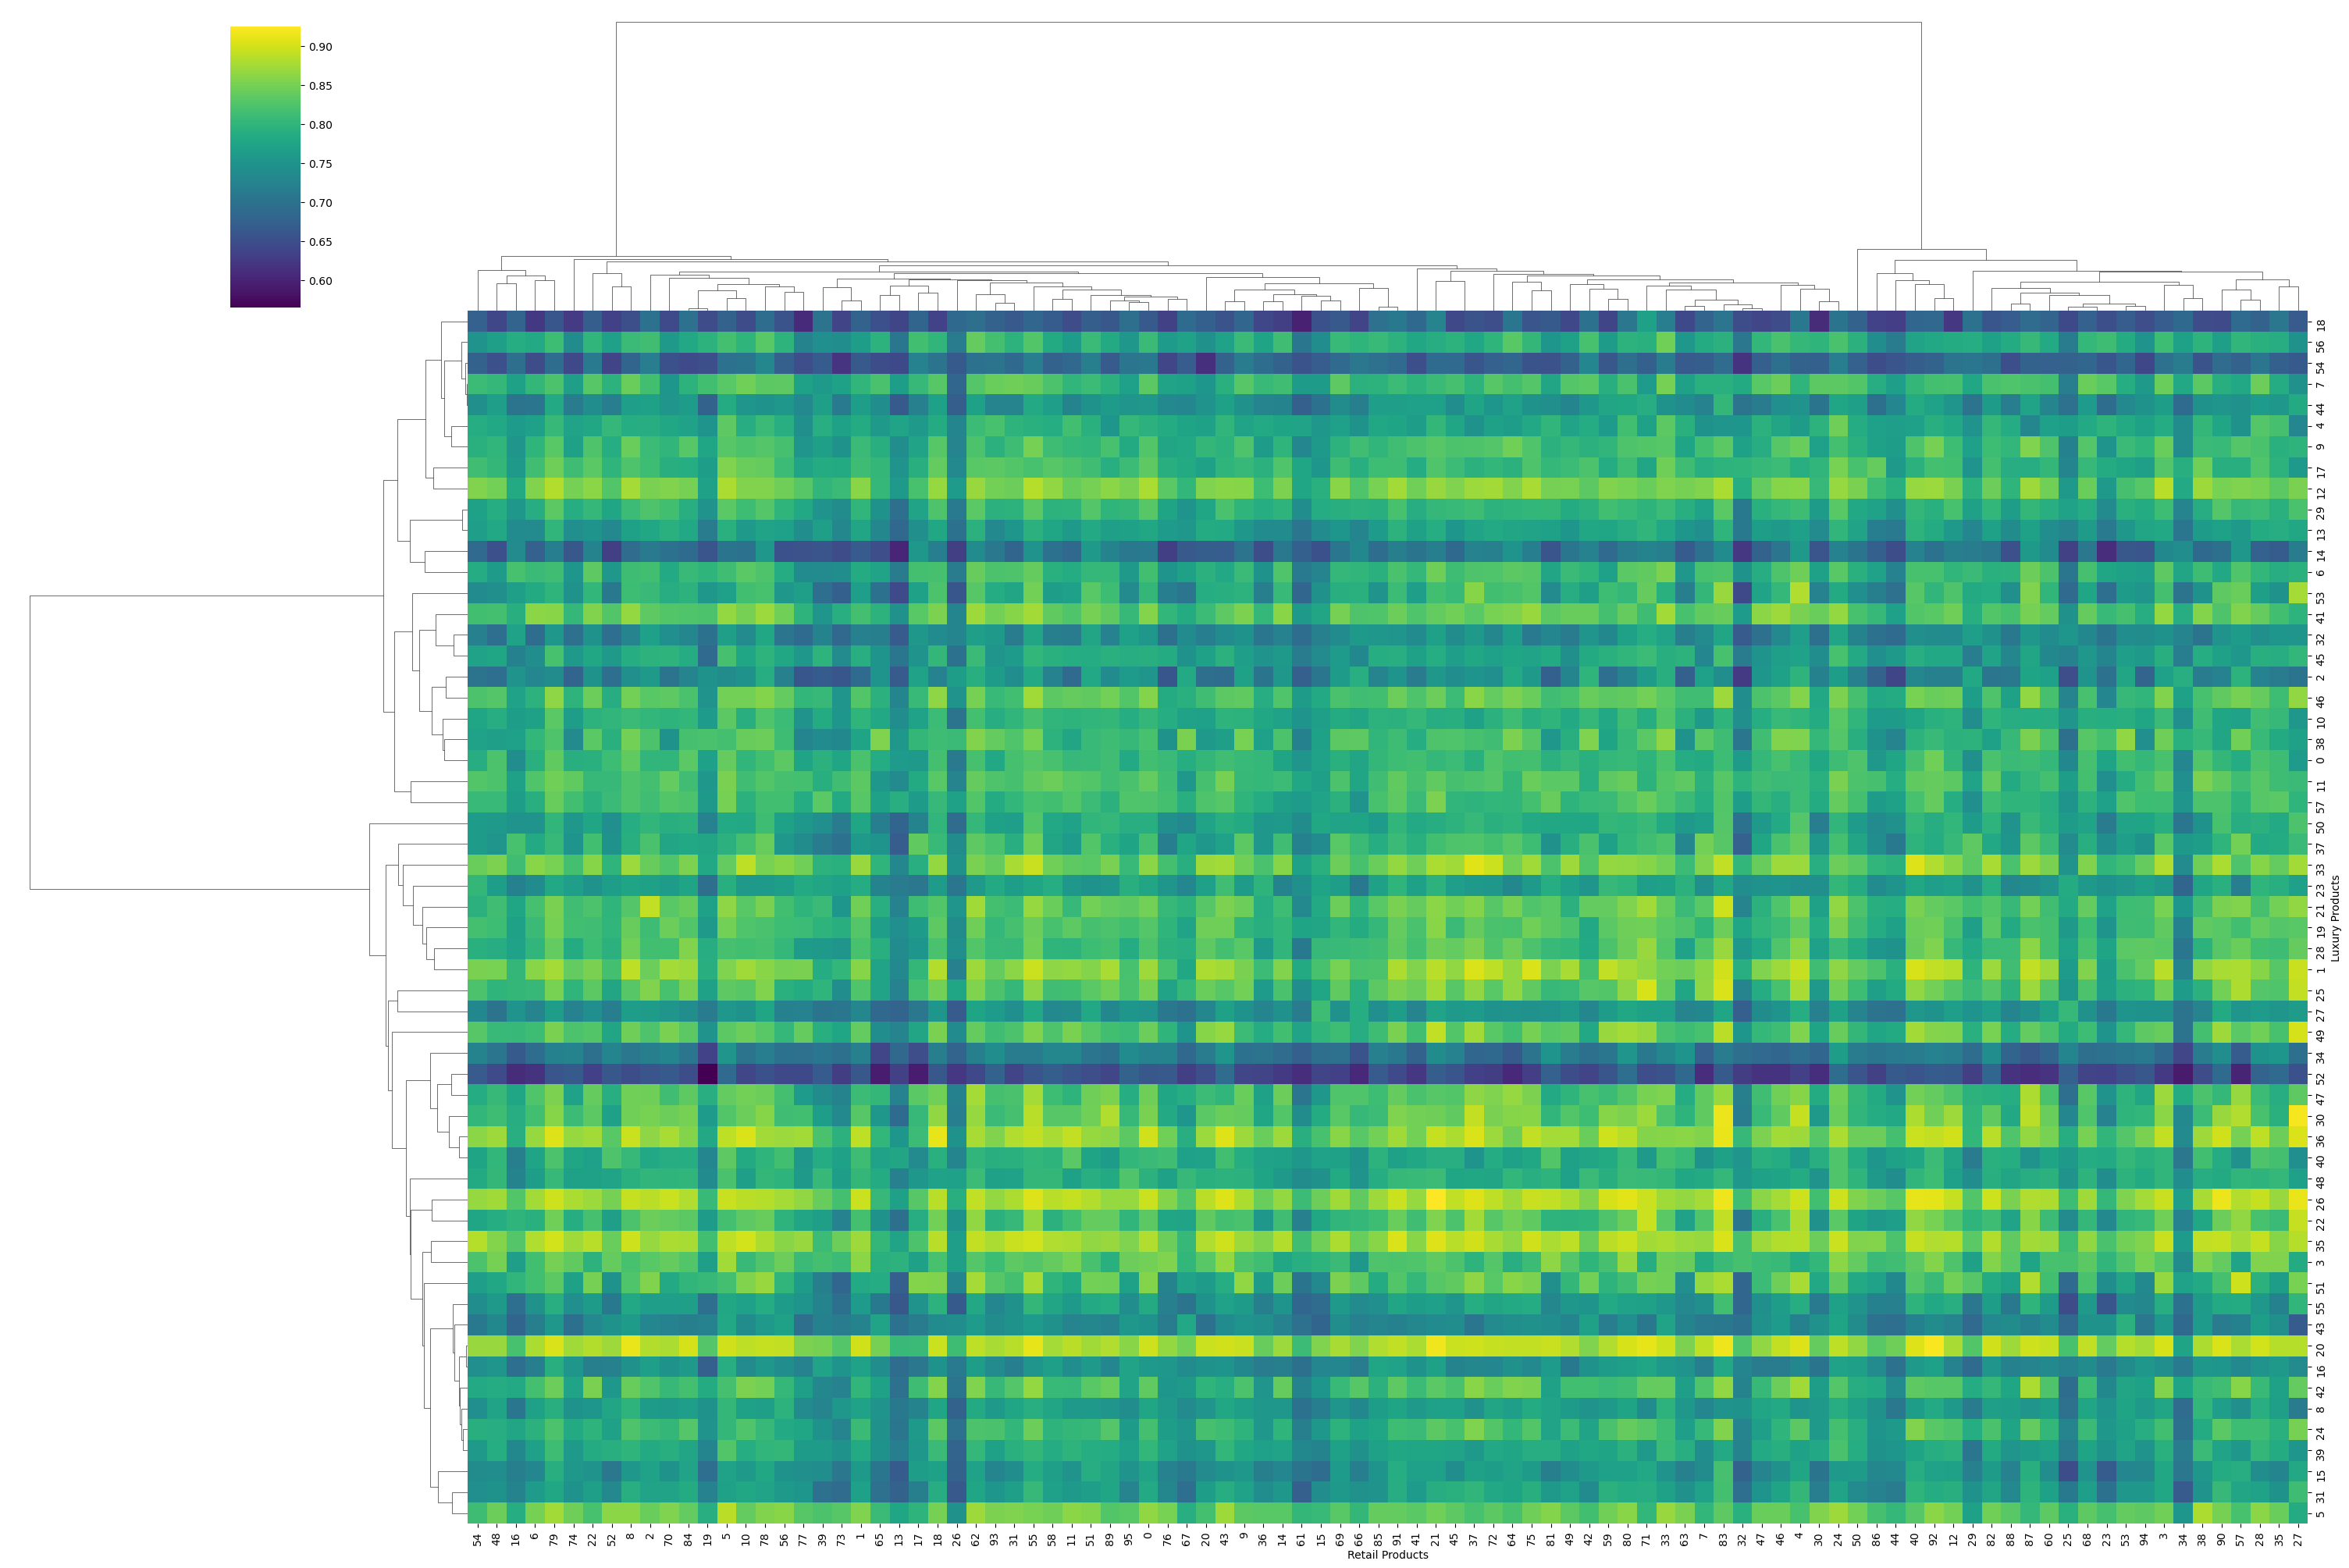

In [47]:
# Reorder the cosine distance dataframe
ordered_cosine = distances_df.loc[luxury_order, retail_order]

# Plot the hierarchical clustering heatmap with adjusted figure size
clustermap = sns.clustermap(
    ordered_cosine,
    row_linkage=luxury_linkage,
    col_linkage=retail_linkage,
    cmap='viridis',
    figsize=(30, 20),  # Set the figure size here
    dendrogram_ratio=(0.2, 0.2),  # Adjust the dendrogram ratio if needed
    cbar_pos=(0.1, 0.8, 0.03, 0.18)  # Adjust the color bar position if needed
)

# Add axis labels
clustermap.ax_heatmap.set_xlabel('Retail Products')
clustermap.ax_heatmap.set_ylabel('Luxury Products')

plt.show()

In [48]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib.pyplot import figure

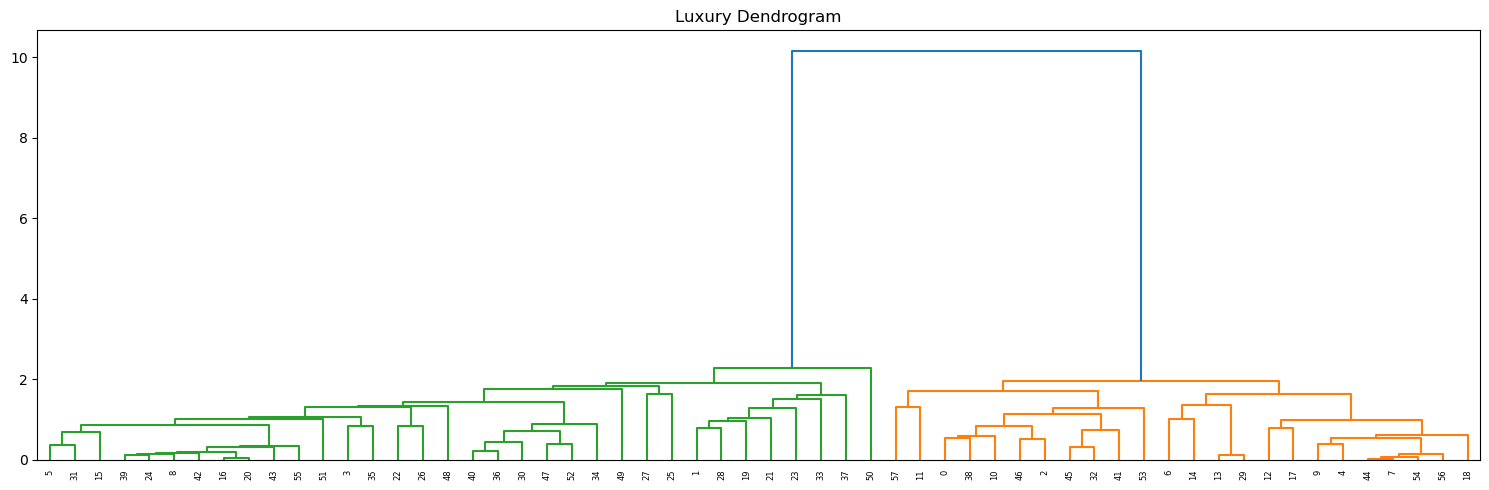

In [49]:
# Plot the dendrograms separately
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot dendrogram for luxury
dendrogram(luxury_linkage, labels=luxury_order, ax=ax, leaf_rotation=90)
ax.invert_xaxis()

plt.title('Luxury Dendrogram')
plt.tight_layout()
plt.show()

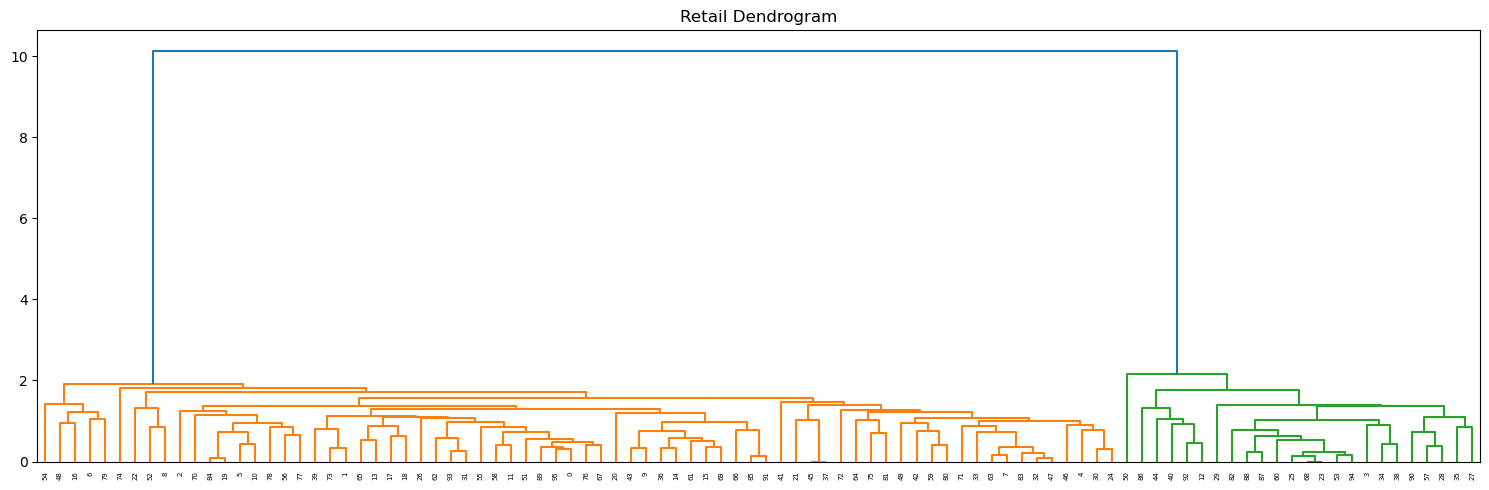

In [50]:
# Plot the dendrograms separately
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot dendrogram for luxury
dendrogram(retail_linkage, labels=retail_order, ax=ax, leaf_rotation=90)
plt.title('Retail Dendrogram')
plt.tight_layout()
plt.show()

### Check specific luxury vs retail

In [51]:
luxury_df[luxury_df.prod_id == 20]

,prod_id,Summary,Brand,Price,breathability,collar style,colors,details and embellishments,fabric weight,fit,...,pocket placement,pocket presence,pocket size,shape,sleeve style,texture,transparency,type,seasson,Summary_treated
10,20,The top showcased in the images is a luxurious...,Gucci,1400.0,High,Crew neck,"50% brown, 30% white, 20% green","Stripes, printed design",Light,Regular fit,...,Not applicable,No,Not applicable,Fitted,Long sleeve,Smooth,Opaque,"Top, Shirt","Spring, Summer",top showcased image luxurious gucci shirt desi...


In [52]:
retail_df[retail_df.prod_id == 92]

,prod_id,Summary,Brand,Price,breathability,collar style,colors,details and embellishments,fabric weight,fit,...,pocket placement,pocket presence,pocket size,shape,sleeve style,texture,transparency,type,seasson,Summary_treated
40,92,The top showcased in the images is a fluid fab...,Mango,39.99,High,Not applicable,White (100%),Buttons,Light,Loose,...,Not applicable,No,Not applicable,Boxy,Long sleeve,Smooth,Semi-transparent,Top,"Spring, Summer",top showcased image fluid fabric shirt straigh...
